In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

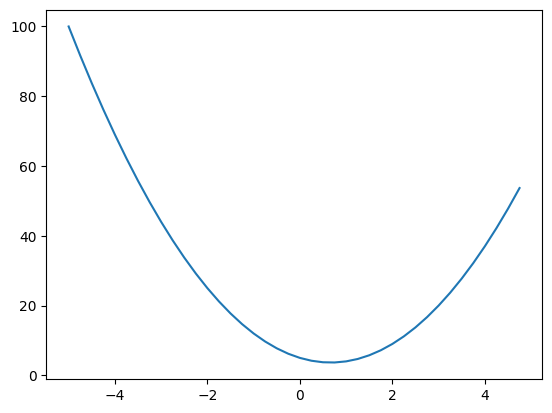

In [6]:
xs = np.arange(-5, 5, 0.25)
xs
ys = f(xs)
ys
plt.plot(xs, ys)

In [7]:
h = 0.00000001
x = 3.0
(f(x+h)-f(x))/h

14.00000009255109

In [8]:
x = -3.0
(f(x+h)-f(x))/h

-22.00000039920269

In [10]:
h = 0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [11]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [16]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# a += h
b += h
# c += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2-d1)/h)

d1: 4.0
d2: 4.0002
slope: 2.0000000000042206


In [42]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return 'Value(data={})'.format(self.data)
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad = other * self.data ** (other-1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a + b
a.__add__(b)
a*b
a.__mul__(b)
d = a*b + c
d
a.__mul__(b).__add__(c)

Value(data=4.0)

In [95]:
a = Value(2)
a + 1

Value(data=3)

In [96]:
a * 2

Value(data=4)

In [97]:
2 * a

Value(data=4)

In [109]:
# a/b
# a*b**-1
a = Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5)

In [112]:
a - b

Value(data=-2.0)

In [58]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [59]:
d._op

'+'

In [60]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

In [33]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})# rank direction: left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid+n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

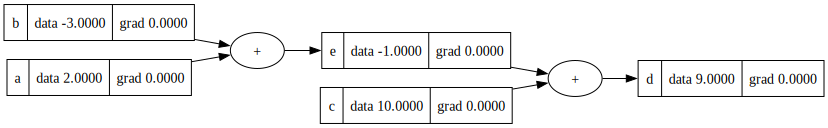

In [73]:
draw_dot(d)

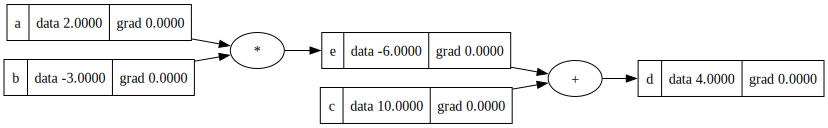

In [77]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
draw_dot(d)

In [81]:
f = Value(-2.0, label = 'f')
L = d*f
L.label = 'L'
L

Value(data=-8.0)

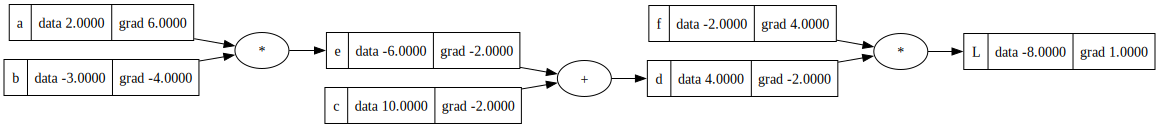

In [102]:
draw_dot(L)

In [ ]:
L.grad = 1.0

L = d * f

dL/dd = ?

(f(x+h)-f(x))/h
= ((d+h) * f - d * f)/h
= (d * f + h * f - d * f)/h
= (h * f)/h
= f

In [89]:
f.grad = 4.0
d.grad = -2.0

dd / dc = ?

d = c + e

(f(x+h) - f(x))/h
= (c + h + e - (c + e))/h
= h/h
= 1

dd/dc = 1.0
dd/de = 1.0
d = c + e

WANT:
dL/dc = (dL/dd) * (dd/dc)

KNOW:
dL/dd
dd/dc

In [97]:
c.grad = -2.0
e.grad = -2.0

dL/de = -2.0

e = a * b
de/da = ? 
de/da = b

dL/da = (dL/de) * (de/da)

In [101]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [105]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [104]:
def lol():
    
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f
    L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0 + h, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f
    L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

-3.9999999999995595


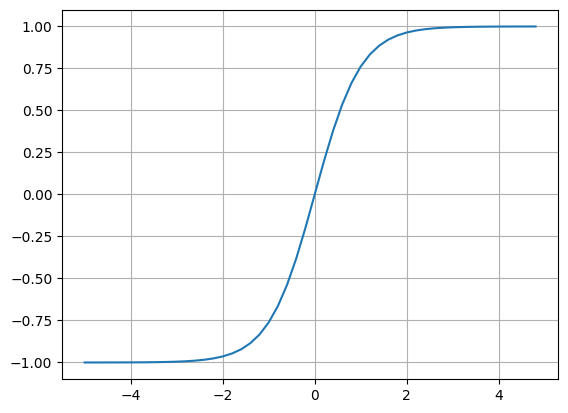

In [108]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [118]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron 
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()

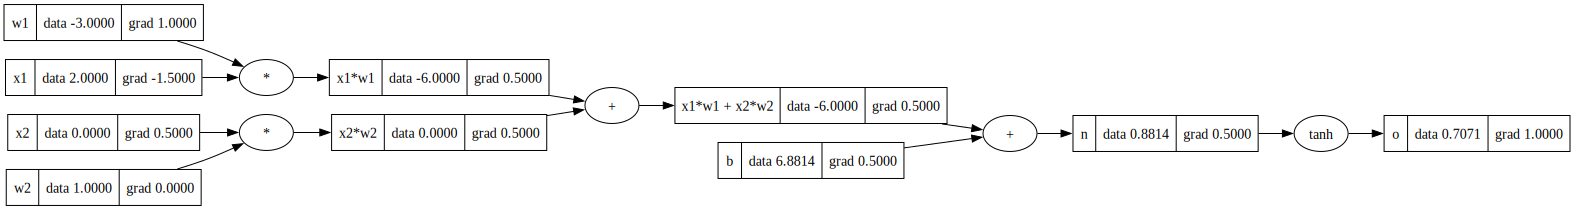

In [119]:
draw_dot(o)

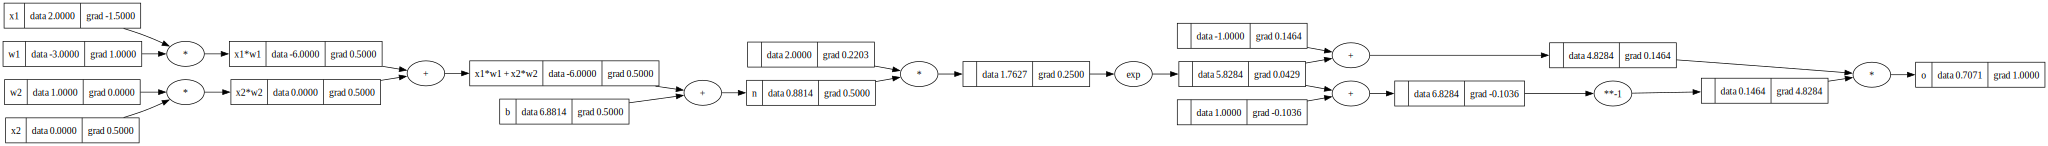

In [121]:
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron 
b = Value(6.8813735870195432, label = 'b')
# x1w1 + x2w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
# o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

In [128]:
import torch

In [139]:
a = torch.Tensor([[2, 4, 6], [1, 3, 5]]).double()
a

tensor([[2., 4., 6.],
        [1., 3., 5.]], dtype=torch.float64)

In [140]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]); b.require_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [80]:
o.backward()

In [59]:
o.grad = 1.0

In [61]:
o._backward()

In [67]:
n._backward()

In [69]:
b._backward()

In [71]:
x1w1x2w2._backward()

In [73]:
x1w1._backward()
x2w2._backward()

In [27]:
o.grad = 1.0

In [28]:
# o = tanh(n)
# do/dn = 1 - o**2

In [29]:
1 - o.data**2

0.4999999999999999

In [30]:
n.grad = 0.5

In [31]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [33]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [34]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [35]:
x2.grad = w2.grad * x2w2.grad
w2.grad = x2.grad * x2w2.grad

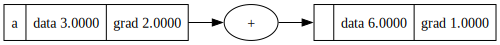

In [88]:
a = Value(3.0, label = 'a')
b = a + a
b.backward()
draw_dot(b)

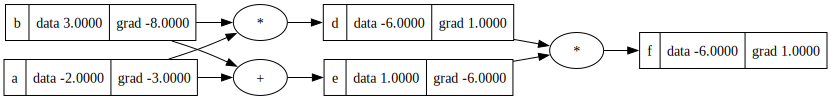

In [89]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

In [73]:
import random
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#         params = []
#         for neuron in self neurons:
#             ps = neuron.parameters()
#             params.extend(ps)
#         return params
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.2958703786853228)

In [123]:
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=-0.5374415928691015),
 Value(data=-0.8983717243507389),
 Value(data=0.22946369918603732)]

In [107]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6479335736545078)

In [125]:
n.parameters()

[Value(data=-0.8371649819981211),
 Value(data=-0.24425704372149437),
 Value(data=0.44334222845928917),
 Value(data=0.2067617855670727),
 Value(data=0.22201335392334287),
 Value(data=-0.848188919830325),
 Value(data=-0.2377088362581512),
 Value(data=-0.6672075997509905),
 Value(data=0.2381405908723211),
 Value(data=-0.671022533477607),
 Value(data=0.7255996645962441),
 Value(data=0.5306539113199253),
 Value(data=0.7661947811481704),
 Value(data=-0.9958212607820374),
 Value(data=-0.08020257688062404),
 Value(data=0.10775612866074158),
 Value(data=0.01679911034984216),
 Value(data=-0.31975026819539276),
 Value(data=0.9148697152065903),
 Value(data=0.8283824824774455),
 Value(data=0.5390083266826411),
 Value(data=-0.5202808181595135),
 Value(data=-0.37544113244930366),
 Value(data=0.3451216139561326),
 Value(data=-0.6005554776518156),
 Value(data=-0.6640006048528178),
 Value(data=-0.02142179373032982),
 Value(data=-0.15205960362572912),
 Value(data=-0.7133343780819976),
 Value(data=-0.7111

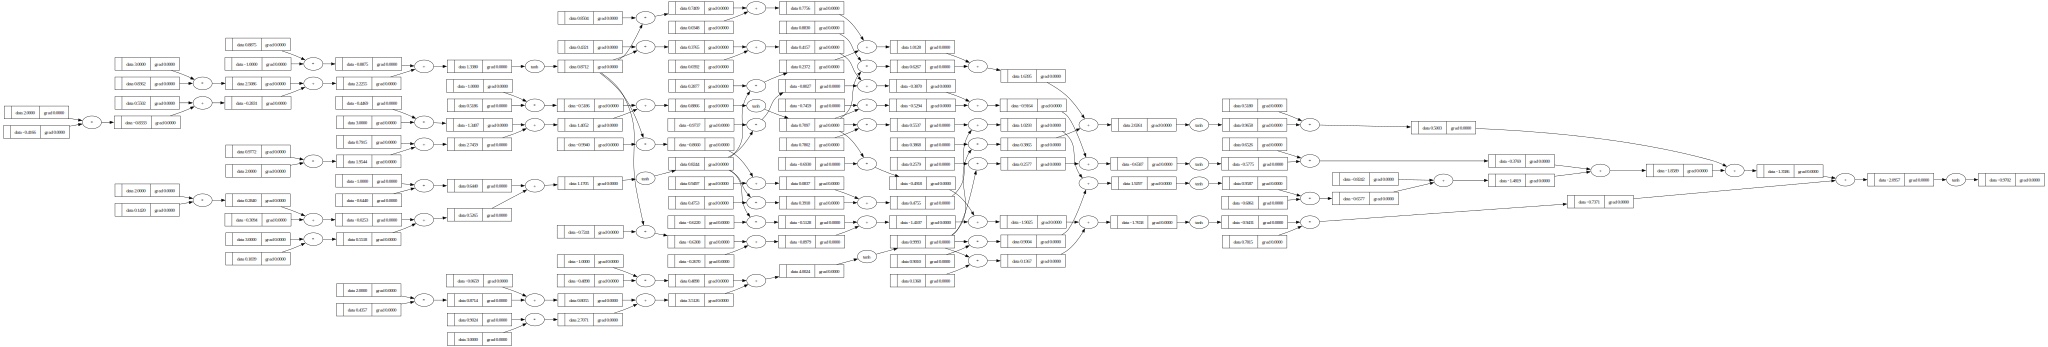

In [37]:
draw_dot(n(x))

In [108]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [184]:
ypred = [n(x) for x in xs]
print(ypred)
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

[Value(data=0.9998370343688101), Value(data=-0.9975916082920046), Value(data=-0.9997215577449776), Value(data=0.9998313416650655)]


Value(data=5.9328841394151916e-06)

In [185]:
loss.backward()

In [106]:
# draw_dot(loss)

In [59]:
n.layers[0].neurons[0].w[0].grad

0.24181554871075733

In [60]:
n.layers[0].neurons[0].w[0].data

0.6823432346471248

In [186]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [64]:
n.layers[0].neurons[0].w[0].data

0.6775069236729097

In [121]:
ypred

[Value(data=0.9999999970594052),
 Value(data=0.9999999974577001),
 Value(data=0.9999999971543085),
 Value(data=0.9999999970598797)]

In [110]:
for k in range(100):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(k, loss.data)

0 0.0024843490705528286
1 0.002458697644400405
2 0.002433572282955507
3 0.002408956970135011
4 0.002384836333120321
5 0.0023611956104038385
6 0.002338020621720226
7 0.002315297739733919
8 0.0022930138633647126
9 0.0022711563926415866
10 0.002249713204984163
11 0.002228672632817686
12 0.002208023442435165
13 0.002187754814026585
14 0.002167856322800258
15 0.0021483179211277646
16 0.00212912992164813
17 0.0021102829812716995
18 0.002091768086028414
19 0.0020735765367088546
20 0.0020556999352502043
21 0.0020381301718224785
22 0.0020208594125731344
23 0.0020038800879916253
24 0.001987184881857316
25 0.001970766720737151
26 0.0019546187640012455
27 0.0019387343943270752
28 0.0019231072086644241
29 0.0019077310096353656
30 0.0018925997973449776
31 0.001877707761580017
32 0.0018630492743745035
33 0.0018486188829220616
34 0.0018344113028162705
35 0.001820421411601698
36 0.0018066442426187964
37 0.0017930749791274449
38 0.0017797089486942161
39 0.0017665416178300193
40 0.0017535685868648966
41 

In [111]:
ypred

[Value(data=0.9836073028106717),
 Value(data=-0.986783614296469),
 Value(data=-0.9847558469990587),
 Value(data=0.9765815469705257)]